In [1]:
import pandas as pd
import numpy as np
import math
import sklearn
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# settings

# define combinations that are to be tested
combinations = [(["r","g","b"],"RGB"),(["r","g","b","dsm"],"RGB+DSM"),
               (["r","g","b","re"],"RGB+RE"),(["r","g","b","nir"],"RGB+NIR"),
               (["r","g","b","dsm","nir","re"],"RGB+DSM+NIR+RE")]
input_data_path = "sampled_2.csv"

## Import Data

In [3]:
df = pd.read_csv(input_data_path,low_memory=False)

In [4]:
df

,x,y,train,test,merged_5_1,merged_5_2,merged_5_3,merged_5_4,merged_5_5,merged_5_6,merged_5_7,merged_5_8,merged_5_9
0,319903.8164,6843727.743,NaN,NaN,-35.74009,0.0,0.0,0.0,0.0,88.0,72.0,77.0,255.0
1,319903.8664,6843727.743,NaN,NaN,-35.74701,0.0,0.0,0.0,0.0,32.0,24.0,29.0,255.0
2,319903.9164,6843727.743,NaN,NaN,-35.75975,0.0,0.0,0.0,0.0,8.0,7.0,8.0,255.0
3,319903.9664,6843727.743,NaN,NaN,-35.76017,0.0,0.0,0.0,0.0,39.0,18.0,31.0,255.0
4,319904.0164,6843727.743,NaN,NaN,-35.77869,0.0,0.0,0.0,0.0,13.0,15.0,16.0,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280218,319897.2171,6843615.508,NaN,NaN,-36.70755,5758.0,65535.0,6984.0,65535.0,50.0,55.0,60.0,255.0
3280219,319897.2671,6843615.508,NaN,NaN,-36.71937,5951.0,65535.0,6861.0,65535.0,51.0,53.0,59.0,255.0
3280220,319897.3171,6843615.508,NaN,NaN,-36.75003,5637.0,65535.0,7047.0,65535.0,77.0,72.0,62.0,255.0
3280221,319897.3671,6843615.508,NaN,NaN,-36.74512,5473.0,65535.0,7917.0,65535.0,16.0,20.0,12.0,255.0


In [5]:
df.columns = ["x","y","train","test","dsm","re","re2","nir","nir2","r","g","b","alpha"]

In [6]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,x,y,dsm,re,re2,nir,nir2,r,g,b,alpha
count,3280223.00000,3280223.00000,3280223.00000,3280223.00000,3280223.00000,3280223.00000,3280223.00000,3280223.00000,3280223.00000,3280223.00000,3280223.00000
mean,319898.18840,6843672.69141,-36.41859,16029.59990,64460.19917,17902.60827,64655.05265,126.13685,127.22482,108.11254,255.00000
std,23.17302,29.99977,1.30195,9530.10157,8323.57474,10157.78073,7542.74881,66.84854,63.12405,59.65089,0.00000
min,319847.27180,6843615.50800,-38.38610,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000
25%,319879.61870,6843647.25400,-37.38474,9006.00000,65535.00000,10209.00000,65535.00000,68.00000,71.00000,56.00000,255.00000
50%,319898.26700,6843672.75000,-36.50815,14972.00000,65535.00000,16978.00000,65535.00000,129.00000,129.00000,104.00000,255.00000
75%,319916.66520,6843698.29700,-36.06096,21377.00000,65535.00000,23918.00000,65535.00000,183.00000,181.00000,157.00000,255.00000
max,319950.36200,6843727.74300,-26.23309,65535.00000,65535.00000,65535.00000,65535.00000,255.00000,255.00000,255.00000,255.00000


## Prepare Data

In [7]:
# clean up target columns
df_train = df["train"]
tmp = []
for i in df_train:
    a = str(i)
    if a == "nan":
        tmp.append("")
    else:
        tmp.append(i)
df["train"] = tmp

df_test = df["test"]
tmp = []
for i in df_test:
    a = str(i)
    if a == "nan":
        tmp.append("")
    else:
        tmp.append(i)
df["test"] = tmp

# extract train and test datasets
df_train = df[df["train"] != ""]
df_test = df[df["test"] != ""]

## Define RF function

In [14]:
def rf(columns,title,data):

    
    # extract train data
    x_train = data[data["train"] != ""][columns] # filter for rows part of training set and their according columns
    y_train = data[data["train"] != ""]["train"] # filter for rows part of training set and their target column
    
    # extract test data
    x_test = data[data["test"] != ""][columns]
    y_test = data[data["test"] != ""]["test"]

    # stratify samples
    #x_train, _, y_train, _ = train_test_split(x_test, y_test,stratify=y_test, test_size=7)
    
    
    # define and train RF
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=750,max_depth=None,n_jobs=8,verbose=0)
    clf.fit(x_train,y_train)
    
    # perform predition on test set
    pred = clf.predict(x_test)
    
    # get scores on train dataset
    acc = sklearn.metrics.accuracy_score(y_test,pred)
    print("Accuracy based on Columns",title," : ",round(acc,3))
    
    # show confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    sklearn.metrics.plot_confusion_matrix(clf, x_test, y_test ,values_format = '.5g',ax=ax)
    plt.title("Confusion Matrix for Features: "+title)
    plt.savefig(title+'.png')
    plt.show()
    
    # show feature importance
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature Importances using MDI for: "+str(title))
    ax.set_ylabel("Mean Decrease in Impurity")
    plt.savefig(title+'featureImportance.png')
    fig.tight_layout()
    
    # perform prediction on whole dataset
    x_full_pred = df[columns] # extract full data
    pred_full = clf.predict(x_full_pred) # predict on data
    
    # save final result to new datafrme
    df_export = df[["x","y"]]
    df_export["pred"] = pred_full
    
    return(df_export)

## Perform Predictions and Acccuracy assesment for train,test and complete dataset

Accuracy based on Columns RGB  :  0.74


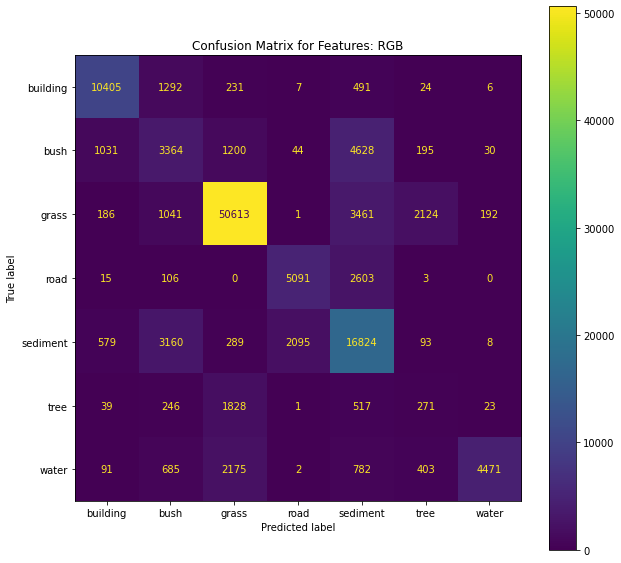

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy based on Columns RGB+DSM  :  0.809


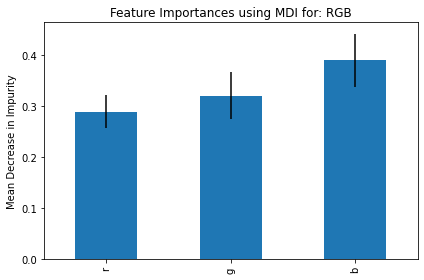

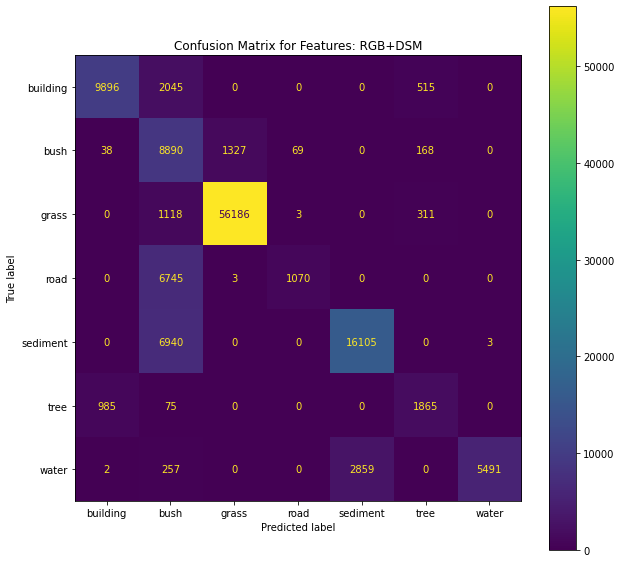

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy based on Columns RGB+RE  :  0.794


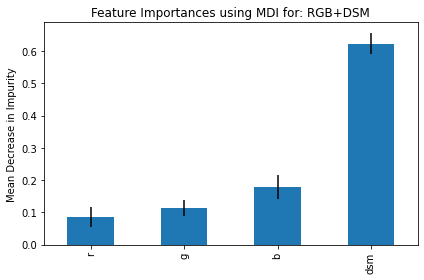

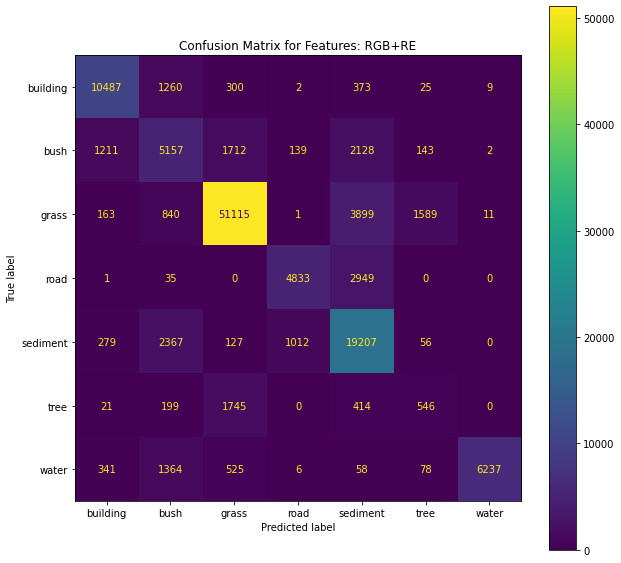

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy based on Columns RGB+NIR  :  0.795


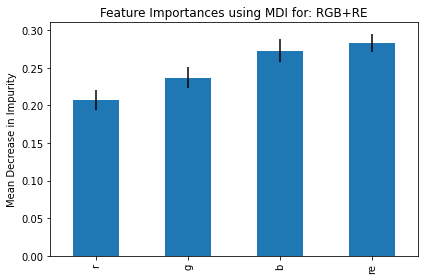

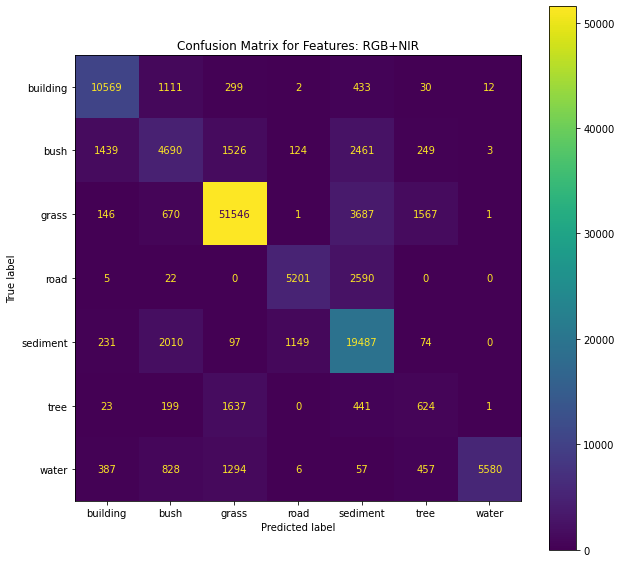

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy based on Columns RGB+DSM+NIR+RE  :  0.846


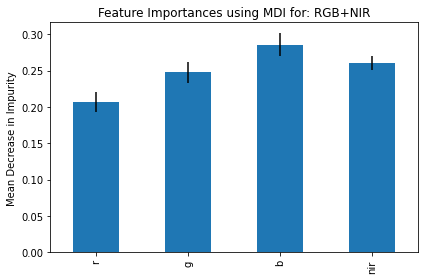

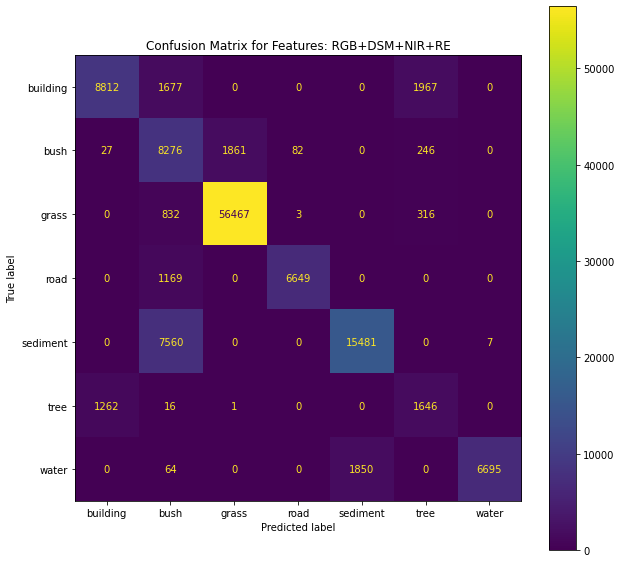

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


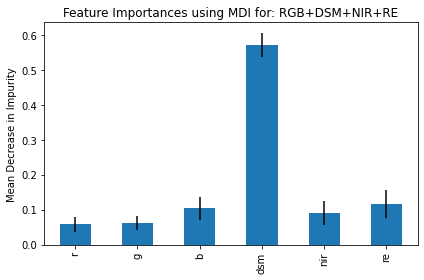

In [15]:
for combi in combinations:
    columns = combi[0]
    title = combi[1]
    complete_pred = rf(columns,title,data=df)
    complete_pred.to_csv(title+".csv")

**Accuracies:**
- Accuracy based on Columns RGB  :  0.74  
- Accuracy based on Columns RGB+DSM  :  0.81  
- Accuracy based on Columns RGB+RE  :  0.793  
- Accuracy based on Columns RGB+NIR  :  0.795  
- Accuracy based on Columns RGB+DSM+NIR+RE  :  0.847